
## 구글 이미지 다운로더 설치

In [ ]:
!git clone https://github.com/Joeclinton1/google-images-download.git

In [ ]:
!cd google-images-download && python setup.py install

In [ ]:
!pip install git+https://github.com/Joeclinton1/google-images-download.git

**런타임** - **런타임 다시 시작** 클릭

## 데이터셋 구성

In [ ]:
# 다운로드 받고자 하는 키워드 정의 (쉼표로 구분, 공백 없음)
keywords = "아이유,뷔,고릴라"

In [ ]:
from google_images_download import google_images_download

response = google_images_download.googleimagesdownload()

arguments = {"keywords": keywords,
             "limit":20, # 최대 다운로드 사진 개수는 100장으로 제한
             "size": "medium",
             "print_urls":True, 
             "format":"jpg"}

paths = response.download(arguments)
print(paths) 

## 사용하지 않는 폴더 삭제

In [ ]:
keywords_list = keywords.split(',')
keywords_list = [f.strip() for f in keywords_list]
keywords_list

['아이유', '뷔', '고릴라']

In [ ]:
import os
import glob

download_folder = 'downloads'

In [ ]:
folder_list = os.listdir(download_folder)
folder_list

['아이유', '고릴라', '뷔']

In [ ]:
exempt_folders = [f for f in folder_list if f.strip() not in keywords_list]
exempt_folders

[]

In [ ]:
for folder in exempt_folders:
    if os.path.isdir(os.path.join(download_folder, folder)):
        files = glob.glob(os.path.join(download_folder, folder) + '/*')
        for f in files:
            os.remove(f)
        os.rmdir(os.path.join(download_folder, folder))

## AutoKeras 설치

In [ ]:
!pip install autokeras

In [ ]:
import autokeras as ak
import numpy as np

## 데이터 시각화

다운로드 받은 이미지 데이터 시각화

Found 60 images belonging to 3 classes.
(32, 224, 224, 3) (32, 3)
[1. 0. 0.]


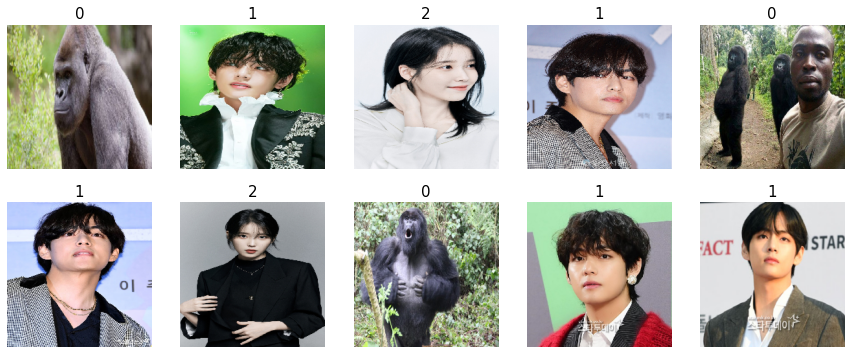

In [ ]:
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 경고 무시
warnings.filterwarnings('ignore')

# TRAIN, TEST 경로 지정
TRAIN_DIR = 'downloads'

# 데이터 시각화 코드
original_datagen = ImageDataGenerator(rescale=1./255)
original_generator = original_datagen.flow_from_directory(TRAIN_DIR, 
                                                          target_size=(224, 224), 
                                                          batch_size=32
                                                         )

for x, y in original_generator:
    print(x.shape, y.shape)
    print(y[0])
    
    fig, axes = plt.subplots(2, 5)
    fig.set_size_inches(15, 6)
    for i in range(10):
        axes[i//5, i%5].imshow(x[i])
        axes[i//5, i%5].set_title(f'{y[i].argmax()}', fontsize=15)
        axes[i//5, i%5].axis('off')
    break
plt.show()

## 디스크(disk) 공간에서 이미지 데이터 로드

In [ ]:
batch_size = 32 
img_height = 224 # 이미지의 세로 사이즈
img_width = 224  # 이미지의 가로 사이즈

train_data = ak.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(224, 224),
    batch_size=batch_size,
    # # Use 20% data as testing data.
    # validation_split=0.2,
    # subset="training",
)

test_data = ak.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
)

Found 60 files belonging to 3 classes.
Found 60 files belonging to 3 classes.
Using 12 files for validation.


## 고급 모델 생성

In [ ]:
# 입력 노드 정의
input_node = ak.ImageInput()

# 출력 노드 정의
output_node = ak.ImageBlock(
    # Only search ResNet architectures.
    block_type="resnet",
    # Normalize the dataset.
    normalize=True,
    # data augmentation.
    augment=False,
)(input_node)

output_node = ak.ClassificationHead()(output_node)

model = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=5
)

In [ ]:
model.fit(train_data,
          validation_data=(test_data),
          epochs=20)

## Image URL로 예측

In [ ]:
from skimage import io

In [ ]:
def predict_image_from_url(url, model):
    # image 다운로드, 로드
    image = io.imread(url)

    # 시각화
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # 스케일, resize
    image = image / 255.0
    image = tf.image.resize(image, size=(224, 224))

    # 예측
    x = image.numpy()
    x = np.expand_dims(x, 0)
    pred = model.predict(x)
    print(f'예측 결과: {pred[0][0]}')

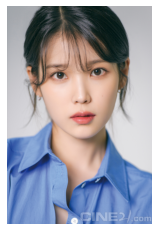

1/1 [==============================] - 0s 21ms/step
예측 결과: 고릴라


In [ ]:
predict_image_from_url('http://image.cine21.com/resize/cine21/article/2022/0603/15_30_27__6299aa83cb210[W578-].jpg', model)

## 학습된 모델 내보내기

In [ ]:
# 모델 내보내기 (저장&백업)
output_model = model.export_model()

print(type(output_model)) 

<class 'keras.engine.functional.Functional'>


In [ ]:
output_model.save("image_model.h5")

INFO:tensorflow:Assets written to: image_model.tf/assets


## 모델 로드

학습이 완료된 샘플 모델을 다운로드 받습니다.

In [ ]:
from keras.models import load_model

In [ ]:
loaded_model = load_model('image_model.h5')